## Import libraries

In [1]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import create_optimizer
from transformers.keras_callbacks import KerasMetricCallback
import evaluate
import numpy as np
from datasets import load_from_disk

c:\Users\Dorian\miniconda3\envs\phishing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read the data 

In [2]:
train_data_path = "../data/processed/dataset/train"
test_data_path = "../data/processed/dataset/test"
val_data_path = "../data/processed/dataset/val"

train_dataset = load_from_disk(train_data_path)
test_dataset = load_from_disk(test_data_path)
val_dataset = load_from_disk(val_data_path)

## Tokenized the text 

In [2]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

c:\Users\Dorian\miniconda3\envs\phishing\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

## Define the metric

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [17]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

## Configure the model

In [ ]:
batch_size = 16
num_epochs = 2
batches_per_epoch = len(tokenized_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

## Create tf Dataset

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_val,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)


## Train the model 

In [ ]:
model.compile(optimizer=optimizer)
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=[metric_callback])

## Save the model 

In [3]:
model_path = "../models/model_ft"
tokenizer_path = "../models/tokenizer"
model_tf_path = "../models/tensorflow_model"

### With transformers

In [ ]:
model.save_pretrained(model_path)

In [ ]:
tokenizer.save_pretrained(tokenizer_path)

### With tensorflow

In [ ]:
model.save(model_tf_path)

## Export in ONNX

In [4]:
from optimum.onnxruntime import ORTModelForSequenceClassification
onnx_path = "../models/onnx/"

ort_model = ORTModelForSequenceClassification.from_pretrained(model_path, export=True)

ort_model.save_pretrained(onnx_path)

tokenizer.save_pretrained(onnx_path)

Framework not specified. Using tf to export the model.


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ../models/model_ft.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.

***** Exporting submodel 1/1: TFDistilBertForSequenceClassification *****
`input_shapes` argument is not supported by the Tensorflow ONNX export and will be ignored.


Using framework TensorFlow: 2.16.1


('../models/onnx/tokenizer_config.json',
 '../models/onnx/special_tokens_map.json',
 '../models/onnx/vocab.txt',
 '../models/onnx/added_tokens.json',
 '../models/onnx/tokenizer.json')

## Evaluate the model 

In [7]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model_path, tokenizer=tokenizer_path, truncation=True)


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ../models/model_ft.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [8]:
inferences = classifier(test_dataset['text'])

### Convert inferences in numeric 

In [24]:
numeric_inferences = [{'label': label2id[inf['label']], 'score': inf['score']} for inf in inferences]
inferences_labels = [lab['label'] for lab in numeric_inferences]

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt 
labels = test_dataset['label']

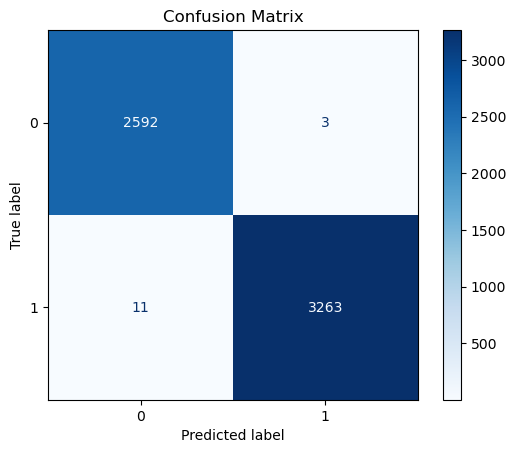

In [28]:
conf_matrix = confusion_matrix(labels, inferences_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels))

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# compute some metrics 
f1_sc = f1_score(labels, inferences_labels)
recall = recall_score(labels, inferences_labels)
precision = precision_score(labels, inferences_labels)
accuracy = accuracy_score(labels, inferences_labels)
print("\nAccuracy:")
print(accuracy)
print("\nRecall:")
print(recall)
print("\nPrecision:")
print(precision)
print("\nF1 Score:")
print(f1_sc)


Accuracy:
0.9976145851081956

Recall:
0.9966401954795358

Precision:
0.9990814451928965

F1 Score:
0.9978593272171253


The results are good with these data with 99% of the mail correctly classified 